In [226]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
%matplotlib inline
colors = ['lightblue', 'pink','darkslategrey']
df_phase1  = pd.read_csv('phase1_lect_ata_new_df.csv')
df_phase2  = pd.read_csv('phase2_lect_ata_new_df.csv')
df = pd.concat([df_phase1,df_phase2])
df_sent  = pd.read_csv('all_w_sent.csv',encoding = "ISO-8859-1")
df_liwc  = pd.read_csv('all_w_liwc.csv',encoding = "ISO-8859-1")

def get_male_female_files(p_male,d_male):
	phase1_files = df_phase1[(df_phase1['isPatientMale']==p_male)&(df_phase1['isDoctorMale']==d_male)]['Filename'].tolist()
	phase2_files = df_phase2[(df_phase2['isPatientMale']==p_male)&(df_phase2['isDoctorMale']==d_male)]['Filename'].tolist()
	return phase1_files+phase2_files

male_doctor_file_names = get_male_female_files(0,1)+ get_male_female_files(1,1)
female_doctor_file_names = get_male_female_files(0,0)+ get_male_female_files(1,0)
male_patient_file_names = get_male_female_files(1,0)+ get_male_female_files(1,1)
female_patient_file_names = get_male_female_files(0,0)+ get_male_female_files(0,1)

maleD_femaleP_file_names = get_male_female_files(0,1)
maleD_maleP_file_names = get_male_female_files(1,1)
femaleD_femaleP_file_names = get_male_female_files(0,0)
femaleD_maleP_file_names = get_male_female_files(1,0)


In [253]:
liwc_features = ['Achievement','Affective','Anger','Anxiety','Biological','Body','Causation','Certainty','Cognitive',\
                 'Discrepancy','Family','Feeling','Fillers','Friends','Future tense','Health','Hearing','Home',\
                 'Humans','Insight','Leisure','Money','Negative Emotion','Positive emotion','Religion','Sadness',\
                 'Sexual','Social','Swear','Time','death@Death']
liwc_features = ['Discrepancy','Cognitive','Affective','Social','Time','Body']
#liwc_features = df_liwc.columns.tolist()[3:]
X = df_liwc.groupby('Filename').mean()[liwc_features]
X = scale(X)

<h2>K-means</h2>

In [254]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
for n in range(2,10,1):
    kmeans = KMeans(init= 'k-means++',n_init= 100, max_iter = 2000, n_clusters=n, random_state=0).fit(X)
    labels = kmeans.labels_
    print(n , silhouette_score(X,labels))



2 0.4309008431528516
3 0.33073771438527755
4 0.25421791668631855
5 0.2341268851036431
6 0.23373498430563103
7 0.22901315165862487
8 0.2031425120167546
9 0.19246008298008963


<h2>Take the best k (=2)</h2>

In [255]:
kmeans = KMeans(init= 'k-means++',n_init= 100, max_iter = 2000, n_clusters=3, random_state=0).fit(X)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
means = []
for k in range(n_clusters_):
    my_members = labels == k
    means.append(df_liwc.groupby('Filename').mean()[my_members].mean()[liwc_features].tolist())

0.31679485844259336 -0.054711246200607855 2.7393617021276597 2.892857142857143


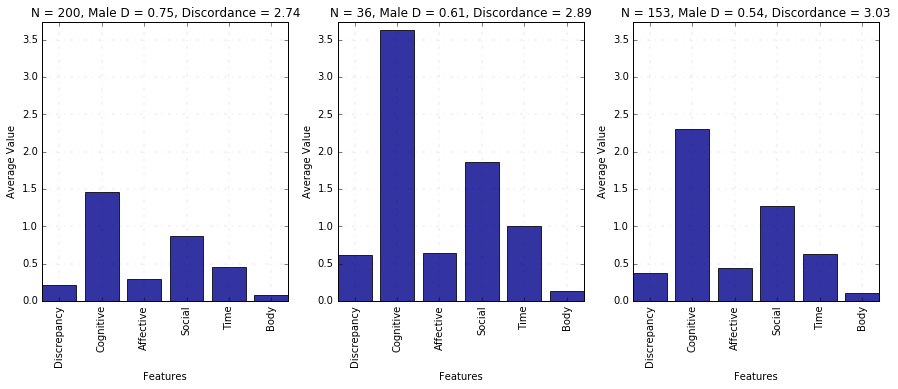

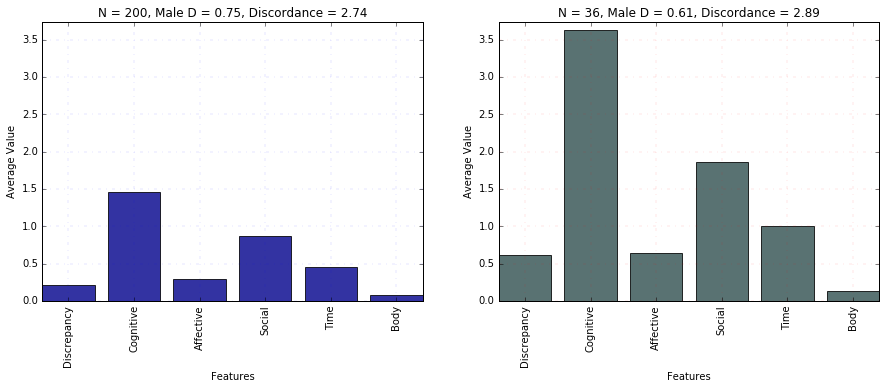

In [257]:
member_files = []
male_percent = []
for k in range(n_clusters_):
    my_members = labels == k
    member_files.append(df_liwc.groupby('Filename').mean()[my_members].reset_index()['Filename'].tolist())
    male_percent.append(len(set(member_files[-1]).intersection(set(male_doctor_file_names)))/len(member_files[-1]))
disc = []
for i in range(len(member_files)):
    disc.append(df[df['Filename'].isin(member_files[i])]['discDmind3'].dropna())
U,p = mannwhitneyu(disc[0],disc[1])
d = 2*U/(len(disc[0])*len(disc[1])) -1
print (p,d,np.mean(disc[0]),np.mean(disc[1]))

y_pos = np.arange(len(liwc_features))
up = np.max(means)+0.1
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
for k in range(n_clusters_):
    plt.subplot(1,n_clusters_,k+1)
    plt.xticks(rotation=90)
    plt.bar(y_pos, means[k], align='center', alpha=0.8,color = 'darkblue')
    plt.axis('tight')
    plt.ylim(0,up)
    plt.xticks(y_pos, liwc_features)
    plt.ylabel('Average Value')
    plt.xlabel('Features')
    plt.title('N = %d, Male D = %0.2f, Discordance = %0.2f' %(len(member_files[k]),male_percent[k],np.mean(disc[k])))
    plt.grid(color='b', linestyle='-.', linewidth=0.1)
plt.show()

y_pos = np.arange(len(liwc_features))
up = np.max(means)+0.1
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.xticks(rotation=90)
plt.bar(y_pos, means[0], align='center', alpha=0.8,color = 'darkblue')
plt.axis('tight')
plt.ylim(0,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Average Value')
plt.xlabel('Features')
plt.title('N = %d, Male D = %0.2f, Discordance = %0.2f' %(len(member_files[0]),male_percent[0],np.mean(disc[0])))
plt.grid(color='b', linestyle='-.', linewidth=0.1)
#plt.show()
plt.subplot(122)
plt.xticks(rotation=90)
plt.bar(y_pos, means[1], align='center', alpha=0.8,color = 'darkslategrey')
plt.axis('tight')
plt.ylim(0,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Average Value')
plt.xlabel('Features')
plt.title('N = %d, Male D = %0.2f, Discordance = %0.2f' %(len(member_files[1]),male_percent[1],np.mean(disc[1])))
plt.grid(color='r', linestyle='-.', linewidth=0.1)
plt.show()

<h2>TSNE Visualization</h2>

(270, 2)
(119, 2)


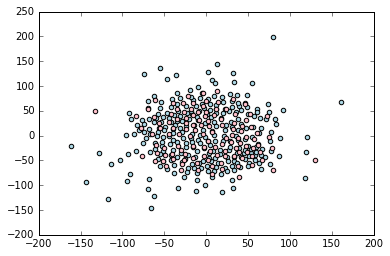

In [249]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

#plt.plot(projection='3d')
mem_feats = []
for k in range(n_clusters_):
    my_members = labels == k
    mem_feats.append(df_liwc.groupby('Filename').mean()[my_members][liwc_features])
    X = np.array(mem_feats[-1])
    X_embedded = TSNE(n_components=2,angle = .5,n_iter=6000).fit_transform(X)
    #X_embedded = PCA(n_components=2).fit_transform(X)
    plt.scatter(X_embedded[:,0],X_embedded[:,1],c = colors[k])
    print(X_embedded.shape)
plt.show()


<h2>Male Doctor only</h2>

In [133]:
X = df_liwc.groupby('Filename').mean().reset_index()
X_unscaled = X[X['Filename'].isin(male_doctor_file_names)]
X = X_unscaled[liwc_features]
X = scale(X)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
for n in range(2,10,1):
    kmeans = KMeans(init= 'k-means++',n_init= 100, max_iter = 2000, n_clusters=n, random_state=0).fit(X)
    labels = kmeans.labels_
    print(n , silhouette_score(X,labels))

2 0.31392710536162083
3 0.15442537215012672
4 0.11834407319109107
5 0.10005580772112058
6 0.06071843929542159
7 0.07371987574622563
8 0.06848945909177259
9 0.05157359722750972


In [215]:
kmeans = KMeans(init= 'k-means++',n_init= 100, max_iter = 2000, n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
means = []
for k in range(n_clusters_):
    my_members = labels == k
    means.append(X_unscaled.groupby('Filename').mean()[my_members].mean()[liwc_features].tolist())

MannwhitneyuResult(statistic=1316.5, pvalue=0.09426065219525054) 3.696969696969697 3.202127659574468


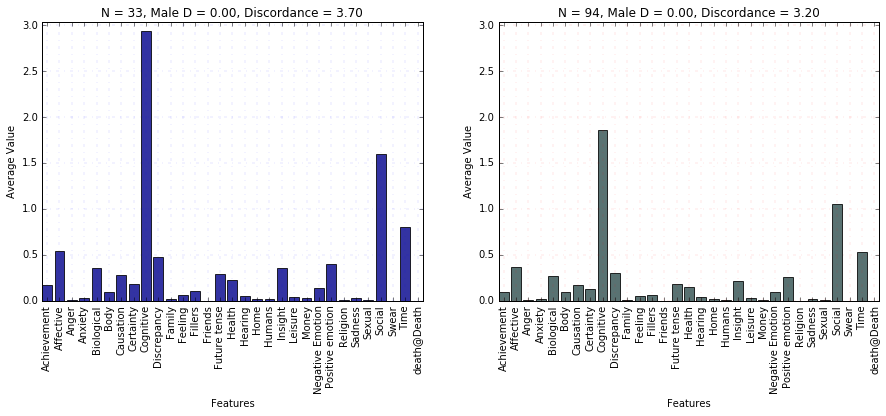

In [216]:
member_files = []
male_percent = []
for k in range(n_clusters_):
    my_members = labels == k
    member_files.append(X_unscaled.groupby('Filename').mean()[my_members].reset_index()['Filename'].tolist())
    male_percent.append(len(set(member_files[-1]).intersection(set(male_doctor_file_names)))/len(member_files[-1]))
disc = []
for i in range(len(member_files)):
    disc.append(df[df['Filename'].isin(member_files[i])]['discDmind3'].fillna(6))
print (mannwhitneyu(disc[0],disc[1]),np.mean(disc[0]),np.mean(disc[1]))


y_pos = np.arange(len(liwc_features))
up = np.max(means)+0.1
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.xticks(rotation=90)
plt.bar(y_pos, means[0], align='center', alpha=0.8,color = 'darkblue')
plt.axis('tight')
plt.ylim(0,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Average Value')
plt.xlabel('Features')
plt.title('N = %d, Male D = %0.2f, Discordance = %0.2f' %(len(member_files[0]),male_percent[0],np.mean(disc[0])))
plt.grid(color='b', linestyle='-.', linewidth=0.1)
#plt.show()
plt.subplot(122)
plt.xticks(rotation=90)
plt.bar(y_pos, means[1], align='center', alpha=0.8,color = 'darkslategrey')
plt.axis('tight')
plt.ylim(0,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Average Value')
plt.xlabel('Features')
plt.title('N = %d, Male D = %0.2f, Discordance = %0.2f' %(len(member_files[1]),male_percent[1],np.mean(disc[1])))
plt.grid(color='r', linestyle='-.', linewidth=0.1)
plt.show()

<h2>Female Doctor Only</h2>

In [212]:
X = df_liwc.groupby('Filename').mean().reset_index()
X_unscaled = X[X['Filename'].isin(female_doctor_file_names)]
X = X_unscaled[liwc_features]
X = scale(X)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
for n in range(2,10,1):
    kmeans = KMeans(init= 'k-means++',n_init= 100, max_iter = 2000, n_clusters=n, random_state=0).fit(X)
    labels = kmeans.labels_
    print(n , silhouette_score(X,labels))

2 0.260884537256157
3 0.09860123608573462
4 0.10365969964730548
5 0.11757700954889219
6 0.07748451504762942
7 0.089083495047974
8 0.10052524875280248
9 0.05856156111766876


In [213]:
kmeans = KMeans(init= 'k-means++',n_init= 100, max_iter = 2000, n_clusters=2, random_state=0).fit(X)
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
means = []
for k in range(n_clusters_):
    my_members = labels == k
    means.append(X_unscaled.groupby('Filename').mean()[my_members].mean()[liwc_features].tolist())

MannwhitneyuResult(statistic=1316.5, pvalue=0.09426065219525054) 3.696969696969697 3.202127659574468


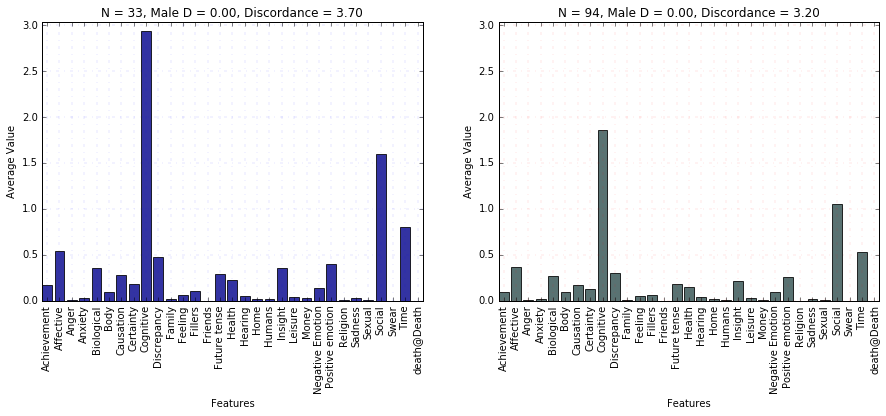

In [214]:
member_files = []
male_percent = []
for k in range(n_clusters_):
    my_members = labels == k
    member_files.append(X_unscaled.groupby('Filename').mean()[my_members].reset_index()['Filename'].tolist())
    male_percent.append(len(set(member_files[-1]).intersection(set(male_doctor_file_names)))/len(member_files[-1]))
disc = []
for i in range(len(member_files)):
    disc.append(df[df['Filename'].isin(member_files[i])]['discDmind3'].fillna(6))
print (mannwhitneyu(disc[0],disc[1]),np.mean(disc[0]),np.mean(disc[1]))


y_pos = np.arange(len(liwc_features))
up = np.max(means)+0.1
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121)
plt.xticks(rotation=90)
plt.bar(y_pos, means[0], align='center', alpha=0.8,color = 'darkblue')
plt.axis('tight')
plt.ylim(0,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Average Value')
plt.xlabel('Features')
plt.title('N = %d, Male D = %0.2f, Discordance = %0.2f' %(len(member_files[0]),male_percent[0],np.mean(disc[0])))
plt.grid(color='b', linestyle='-.', linewidth=0.1)
#plt.show()
plt.subplot(122)
plt.xticks(rotation=90)
plt.bar(y_pos, means[1], align='center', alpha=0.8,color = 'darkslategrey')
plt.axis('tight')
plt.ylim(0,up)
plt.xticks(y_pos, liwc_features)
plt.ylabel('Average Value')
plt.xlabel('Features')
plt.title('N = %d, Male D = %0.2f, Discordance = %0.2f' %(len(member_files[1]),male_percent[1],np.mean(disc[1])))
plt.grid(color='r', linestyle='-.', linewidth=0.1)
plt.show()